# Import Relevant Libraries

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
#from xbbg import blp
import datetime as dt
from statistics import mean
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')


import quant_lib as ql

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Below is the code for the RV strategy
1. The signal expects linear regression residuals to revert back to its mean of 0 if it has deviated too far

In [105]:
ticker_x,ticker_y = 'AAPL',"MSFT"
start_dt,end_dt = '2010-01-01',pd.datetime.today()
rolling_window = 60
tickerlist = [ticker_x,ticker_y]


df = yf.download(tickerlist, period = '1d', start = start_dt,end = end_dt)
df = df.iloc[:,:2]
columns = tickerlist
#df.columns = columns
#Johansen Test
ql.johansen_test(df) #Check for cointegration
df.columns = columns

X = sm.add_constant(df[ticker_x])
Y = df[ticker_y]



rols = RollingOLS(Y,X,window = rolling_window)
rres = rols.fit()

predicted = rres.params[ticker_x]*df[ticker_x] + rres.params['const']
residuals = df[ticker_y] - predicted


df['Residuals'] = residuals
ql.adfuller_test(df.Residuals.dropna())
df['std_window'] = df.Residuals.rolling(window =rolling_window ).std()
df['movingavg'] = df.Residuals.rolling(window = rolling_window).mean()
z_score = (df.Residuals - df.movingavg)/df.std_window
df['residual_z_score'] = z_score

#standardise residuals

[*********************100%***********************]  2 of 2 completed
Time series is co-integrated using Johansen test
Time series is co-integrated using ADF test.


<AxesSubplot:title={'center':'Residuals Z Scores'}, xlabel='Date'>

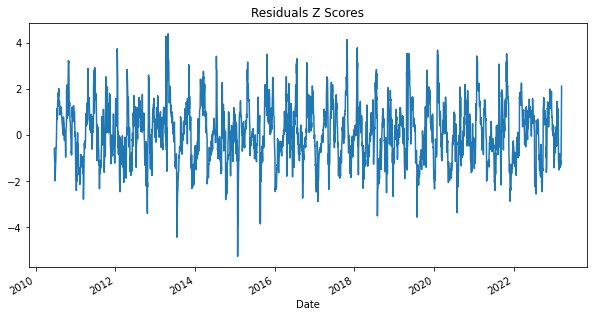

In [106]:
#Residual z-scores
df['residual_z_score'].plot(figsize = (10,5),title = 'Residuals Z Scores')

In [107]:
weights = rres.params[[ticker_x]]
weights.columns = ['ticker_x_beta']
df = pd.concat([df,weights],axis=1)

In [108]:
stock_returns = df[[ticker_x,ticker_y]]
stock_returns = (stock_returns-stock_returns.shift())/stock_returns.shift()
stock_returns.columns = [ticker_x+' Returns',ticker_y+' Returns']
df = pd.concat([df,stock_returns],axis=1)
df

,AAPL,MSFT,Residuals,std_window,movingavg,residual_z_score,ticker_x_beta,AAPL Returns,MSFT Returns
Date,,,,,,,,,
2009-12-31,6.405578,23.265150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,6.505280,23.623898,NaN,NaN,NaN,NaN,NaN,0.015565,0.015420
2010-01-05,6.516528,23.631535,NaN,NaN,NaN,NaN,NaN,0.001729,0.000323
2010-01-06,6.412872,23.486511,NaN,NaN,NaN,NaN,NaN,-0.015907,-0.006137
2010-01-07,6.401017,23.242256,NaN,NaN,NaN,NaN,NaN,-0.001849,-0.010400
...,...,...,...,...,...,...,...,...,...
2023-03-13,150.470001,253.919998,-2.833655,7.029625,2.558012,-0.766992,1.125411,0.013266,0.021441
2023-03-14,152.589996,260.790009,1.740028,6.642045,2.252030,-0.077085,1.127356,0.014089,0.027056
2023-03-15,152.990005,265.440002,5.753650,6.386401,2.070716,0.576684,1.147726,0.002621,0.017830


### Specify the parameters below to run the backtest
1. ticker2y,ticker1x refers to the the 2 asset classes that the RV backtest is to be done on
2. txn_cost: Put in the transaction costs for the trade. It can be in basis points or in percent depending on the asset class in question
3. start_dt: refers to the start date of the backtest
3. end_dt: end date just leave it as today
4. Entry signal: At what residual z score 
5. Take profit: At what zsore level do you want to take profit (There is no absolute return tp for this model)

In [163]:
ticker_x_signals,ticker_y_signals = [0],[0]
ticker_x_exposure,ticker_y_exposure = [0],[0]

max_exposure = 1
cumulative_posns = [0] #this is the same as the exposure of ticker y, make sure cumulative_positions do not exceed the max_exposure above
threshold = 2.1 #Entry
exit = 1.4 #Exit

strategy_returns = []




for i in range(len(df.index)):
    curr_z_score = df['residual_z_score'][i]
    ticker_x_weight = df[ticker_y][i]/df[ticker_x][i]

    #Scenario1: if z-score more than our threshold and the current positions is equal to zero, long x short y
    #Scenario2: if z-score less than negative threshold and the current positions is equal to zero, short x long y
    #Scenario3: If z-score reverts back to zero => close out positions
    #Scenario4: If z-score is between upper/lower thresholds and we have no existing positions
    if cumulative_posns[-1]==0:
        if curr_z_score >=threshold:
            signalx,signaly = ticker_x_weight,-1
        elif curr_z_score <=-threshold:
            signalx,signaly = -ticker_x_weight,1
        else:
            signalx,signaly = 0,0
    else:
        if -exit<=curr_z_score<=exit:
            signalx,signaly = -ticker_x_exposure[-1],-ticker_y_exposure[-1]
        elif curr_z_score <= -threshold and cumulative_posns[-1] < max_exposure:
            signalx,signaly = -ticker_x_weight,1
        elif curr_z_score >= threshold and cumulative_posns[-1]>-max_exposure:
            signalx,signaly = ticker_x_weight,-1
        else:
            signalx,signaly = 0,0
    #Returns for the day is equivalent to the multiple of previous days' exposure to each stock and today's returns of each stock
    returns = (-cumulative_posns[-1] * df[ticker_x+' Returns'][i])+(cumulative_posns[-1]*df[ticker_y+' Returns'][i])
    strategy_returns.append(returns)


    ticker_x_signals.append(signalx)
    ticker_y_signals.append(signaly)
    ticker_x_exposure.append(sum(ticker_x_signals))
    ticker_y_exposure.append(sum(ticker_y_signals))
    cumulative_posns.append(sum(ticker_y_signals))
    
    


In [164]:
df[ticker_x+' signal'] = ticker_x_signals[:-1]
df[ticker_y+' signal'] = ticker_y_signals[:-1]
df[ticker_x+' exposure'] = ticker_x_exposure[:-1]
df[ticker_y+' exposure'] = ticker_y_exposure[:-1]
df['strategy_returns'] = strategy_returns

<AxesSubplot:title={'center':'Equity Pairs Trading REturns (%)'}, xlabel='Date'>

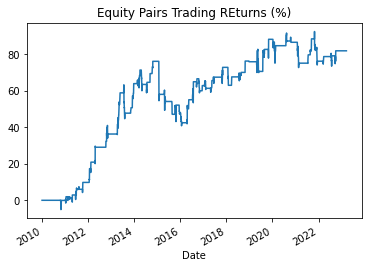

In [165]:
(100*(((1+df['strategy_returns']).cumprod())-1)).plot(title = 'Equity Pairs Trading REturns (%)')

In [117]:
df.to_excel('returns.xlsx')

## Check exposures for each stock

<AxesSubplot:xlabel='Date'>

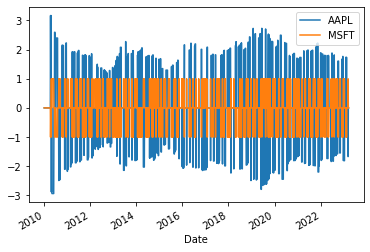

In [343]:
exposures.plot()

## Check for absolute dollar exposures
1. Absolute dollar exposures should be 0 during trade entry in this long/short strategy
2. While holding positions, we may become net long or net short at any point in time if and when each of the stocks' returns are different

<AxesSubplot:xlabel='Date'>

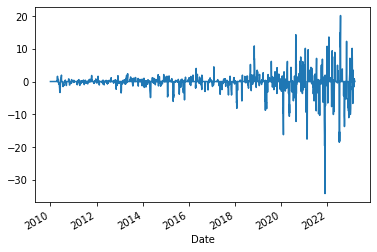

In [344]:
(exposures*df[[ticker_x,ticker_y]]).sum(axis=1).plot()

In [375]:
portfolio_returns = (returns*exposures).sum(axis=1)
portfolio_returns

Date
2009-12-31    0.0
2010-01-04    0.0
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
             ... 
2023-03-13    0.0
2023-03-14    0.0
2023-03-15    0.0
2023-03-16    0.0
2023-03-17    0.0
Length: 3325, dtype: float64